In [1]:
import pandas as pd
from pandas import Series 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import collections
from datetime import datetime
import dateutil
import scipy
import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import dateutil
from dateutil.relativedelta import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import scipy.cluster.hierarchy as spc
import math 

C:\Users\S9632298D\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('./dataport-export_gas_oct2015-mar2016.csv')

In [3]:
#Using group dataframe for meter id and parse datetime with dateutil library
df['localminute']=df['localminute'].apply(dateutil.parser.parse)

group_df = df.groupby(['dataid'])

In [4]:
malfunction_meter_decrease = {}
for meter,house in group_df:
    prev_reading = 0
    for n, meterval in enumerate(house["meter_value"]):
        if (prev_reading) > (meterval + 3):
            malfunction_meter_decrease.setdefault(meter, [])
            malfunction_meter_decrease[meter].append(str(house.iloc[n]["localminute"]))
            
        prev_reading = meterval  

    

In [5]:
malfunction_meter_not_reported={}

for meter,group in group_df:    
    time_diff=0    
    for i in range(len(group['localminute'])):
        if (i!=0):
            time_diff=(group['localminute'].iloc[i]-group['localminute'].iloc[i-1]).total_seconds() / (3600*24) 
        if(time_diff>= 10):
            malfunction_meter_not_reported[meter] = (str(house.iloc[n]["localminute"]))
            break


In [6]:
previous_meter = 0
current_meter = 0
previous_date = ""
malfunction_sudden_increase = {}

for meter, house in group_df:
    for n, dt in enumerate(house['localminute']):   
        current_meter = house.iloc[n]["meter_value"]
        if n == 0:
            previous_date = dt.date()
            
        if previous_date == dt.date():
            previous_meter = house.iloc[n]["meter_value"]
            previous_date = dt.date()
               
        else:
            time = (dt.date() - previous_date)
            day = (time.total_seconds()/(3600*24))
            if (previous_meter - current_meter) / day > 600:
                malfunction_sudden_increase.setdefault(meter, [])
                malfunction_sudden_increase[meter].append(str(house.iloc[n]["localminute"]))
            previous_date = dt.date()
           

In [7]:
malfunction_little_readings = {}
for meter,house in group_df:
    if(len(house['meter_value'])< 200):
        malfunction_little_readings[meter] = len(house['meter_value'])
        

In [8]:
malfunction = {**malfunction_meter_decrease, **malfunction_meter_not_reported, **malfunction_sudden_increase, **malfunction_little_readings}

In [9]:
malfunction_remove = {**malfunction_sudden_increase, **malfunction_meter_decrease,**malfunction_little_readings} 

In [10]:
#Keeping the functional meters and remove the malfunctioning meters
no_malfunction = df[np.logical_not(df["dataid"].isin(malfunction_remove))] 

house_ID = no_malfunction["dataid"].unique()

In [11]:
hourly_data = {}
group_no_malfunction=no_malfunction.groupby('dataid')

for household in house_ID:
    tmp_df = group_no_malfunction.get_group(household)
    tmp_df['meter_value'] = tmp_df['meter_value'] - group_no_malfunction.get_group(household).meter_value.iloc[0]
    tmp_df['localminute'] = pd.to_datetime(tmp_df['localminute'],utc = True)
    tmp = tmp_df.resample('min', on='localminute',label='right').mean().interpolate(method='linear')
    hourly_data[household] = tmp.resample('H').mean().interpolate(method = 'linear')
    temp_hour = pd.DataFrame (hourly_data[household])

    

C:\Users\S9632298D\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\S9632298D\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [12]:
hourly_data_df = pd.DataFrame()
for key in hourly_data:
    frame = [hourly_data_df, hourly_data[key]]
    hourly_data_df = pd.concat(frame, axis=1)
    
hourly_data_df.drop(["dataid"], axis = 1, inplace = True)
hourly_data_df.columns = hourly_data.keys()
hourly_data_df = hourly_data_df.fillna(method='bfill')
hourly_data_df = hourly_data_df.fillna(method='ffill')


In [13]:
correlation = hourly_data_df.corr()
lowest_correlation_meter = {}
correlation.reset_index()
top_correlation_meter = {}

for ID in house_ID:
    top_correlation_meter[ID] = correlation.loc[ID].sort_values(ascending = False).index[1:6]
    lowest_correlation_meter[ID] = correlation.loc[ID].sort_values(ascending = False).index[-5:]
top_correlation_meter = pd.DataFrame(top_correlation_meter)
lowest_correlation_meter = pd.DataFrame(lowest_correlation_meter)

In [14]:
def preprocessed_data(id):
    train_sample = pd.DataFrame(hourly_data_df.iloc[:][id].values)
    dataset_size = len(train_sample)
    train_size = math.trunc(0.8 * dataset_size)
    date = hourly_data_df.index
    train_date = (date[:train_size][:, None]).astype('datetime64[h]')
    test_date = (date[train_size:dataset_size][:, None]).astype('datetime64[h]')
    train_data_duplicate = train_sample.iloc[:train_size]
    test_data_duplicate = train_sample.iloc[train_size:]
    train_data = train_sample.iloc[:train_size]
    test_data = train_sample.iloc[train_size:]
    new_date_range = np.array(list(pd.date_range('2016-04-01T05', periods=2200, freq='H')), dtype='datetime64')[:, None].astype("datetime64[h]")
    
    return train_data, test_data, test_date, train_date, new_date_range, train_data_duplicate, test_data_duplicate

# Question 3 : Further Analysis

# 1. Dynamic Time Warping

Firstly our dataset is a time series dataset, it means that the data points are indexed in time order. 

For Time Series analysis, there will be times whereby the two time series are similar but they are misaligned in the time axis; so, if we use traditional Euclidean distance matching then it will produce a poor similarity score. Hence, this is where dynamic time warping algorithm can be used to measure the similarity or dissimilarity between the two temporal sequences or series that may varies in speed. It can be applied to many temporal sequences of video, audio and graphics data. It calculation typically involves converting the data into vectors; subsequently, calculating the optimal Euclidean distance between those points in the vector space which is known as the warping function. Following on, the warping function will then be applied to both the time series which will transform them into two new time series that are aligned in the time axis. Subsequently, the new optimal distance of each of the time series can then be represented using the distance matrix. Basically, it is used to measure the optimal match distance between two-time series. 

#### Why is Dynamic Time Warping useful in this case? 

Firstly, if we use Euclidean distance only for the measurement of the two time series; as a result, it will produce a poor similarity score as mentioned before. However, if DTW is used, the end result is a more intuitive similarity measure because DTW allows a non-linear alignment between the two time series. Essentially, this allows the similar shapes to match even if they are out of phase in the time axis. However, the time complexity for this algorithm is O(m x n) which might take awhile for large datasets.


In [15]:
from tslearn.metrics import *
from tslearn.preprocessing import *

In [16]:
DTW_data = []
temporary_list = []
meter_ID = list(hourly_data_df.columns)
for column in meter_ID:
    for data in hourly_data_df.iloc[:][column].values:
        temporary_list.append(data)
        
    DTW_data.append(temporary_list)
    temporary_list = []


In [ ]:
DTW_data_normalized = TimeSeriesScalerMinMax(value_range=(0., 1.)).fit_transform(DTW_data)
DTW_data_distance_matrix = cdist_dtw(DTW_data_normalized)

In [ ]:
print(DTW_data_distance_matrix)

[[0.         0.01758699 0.0227205  ... 0.07886956 0.21178758 0.04026311]
 [0.01758699 0.         0.02011592 ... 0.0838292  0.22784187 0.04324805]
 [0.0227205  0.02011592 0.         ... 0.08459003 0.19535389 0.03727973]
 ...
 [0.07886956 0.0838292  0.08459003 ... 0.         0.07024965 0.04772837]
 [0.21178758 0.22784187 0.19535389 ... 0.07024965 0.         0.12334409]
 [0.04026311 0.04324805 0.03727973 ... 0.04772837 0.12334409 0.        ]]


A brief description for distance matrix, also known as dissimilarity matrix, is a table that shows the distance between pairs of object. So, in our case we have 117 time series; therefore, the distance matrix will be a 117 x 117 matrix because each time series is compared with each of the time series to see their dissimilarity between each other. 

In conclusion for Dynamic Time Warping, we can see that the resulting diagonal of the distance matrix are all 0; the reason for that is because the matrix stores the pairwise distance of each time series which is the dissimilarity between the households.


# 2. Hierarchical Clustering

Hierarchical clustering, H-clustering for short, refers to a series of processes which groups 2 items in a recurring manner. There are two kinds of algorithms but for this project, we would be focusing on the agglomerative technique. The Agglomerative algorithm occurs when a single item forms its own cluster and two of the most similar items would be grouped together. As it further accumulates, the similar items would then continue to be grouped, two at a time, till it becomes one cluster. Every step of the clusters can be represented and displayed in a dendrogram. Hence, in our project, we would be implementing H-clustering by correlating similar items in groups of two as it helps us to identify the possible variations of the data. Therefore, our team would be able to have a business model in order to create a forecast model for every cluster with the clustering results instead of having to create a model for every household.


## Hierachical Clustering using Agglomerative Algorithm (Correlation Matrix)

In [17]:
correlation_matrix = 1 - correlation.values
pw_distance = spc.distance.pdist(correlation_matrix)
linkage_pw = spc.linkage(pw_distance, method='complete')
index_pw = spc.fcluster(linkage_pw, 0.2 * pw_distance.max(), 'distance')

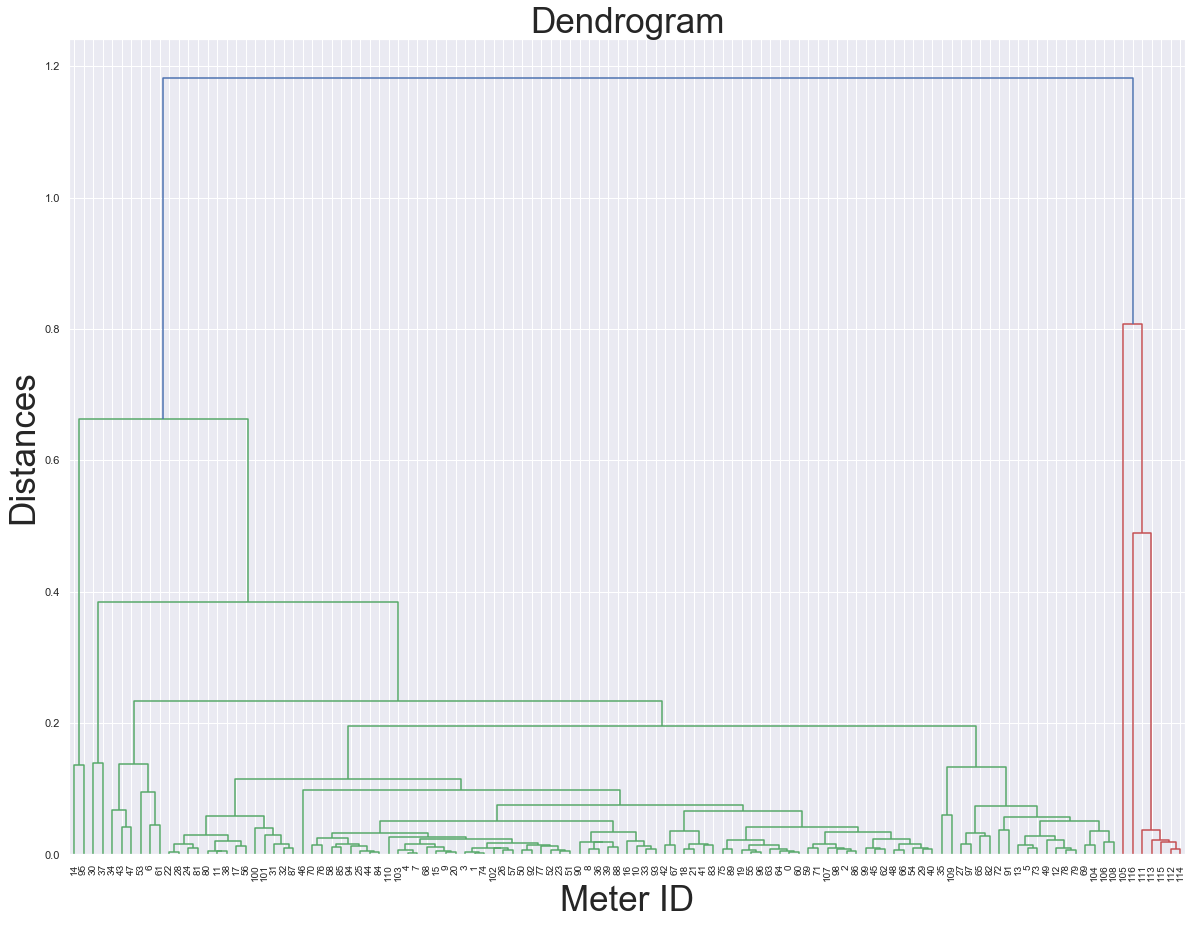

There are a total of 6 clusters. The information is as follows:
Cluster 3: meters 739 6910 3635 1507 4352 1714 9849 5131 6412 7429 871 1086 1589 9631 2034 5275 7287 4296 252 8829 3039 9121 7741 7919 7674 4732 370 9295 3577 35 1697 4767 5785 7739 3367 5972 5439 114 9474 7460 9278 2018 9052 9956 8155 5636 4029 1791 1801 9729 1283 1792 3893 7682 2638 187 3723 5814 77 1619 4421 661 1042 4373 5484 2072 2461 744 1790 1800 2980 2094 5892 7900 8084 3527 3849 4356 2129 2965 2575 8086 1415 2233 6863 2470 3778 2378 6830 9766 4193 8703 4228 6505 5395 8059 7965 44 2945 2818 7016 3310 3918 8386 1103 5658
Cluster 1: meters 4447 6578
Cluster 2: meters 222 8467
Cluster 6: meters 8967
Cluster 4: meters 5317 3036 8244 9600 1403
Cluster 5: meters 6673


In [18]:
def Dendrogram(linkage_pw, index_pw):
    plt.subplots(figsize=(20,15))
    dendrogram = spc.dendrogram(linkage_pw)
    plt.title('Dendrogram', fontsize=35)
    plt.xlabel('Meter ID', fontsize=35)
    plt.ylabel('Distances', fontsize=35)

    plt.xticks(fontsize=10, rotation=90)
    plt.show()
    
    house_cluster = {}
    for i in range(len(index_pw)):
        if index_pw[i] not in house_cluster:
            house_cluster[index_pw[i]] = ""
    for i in range(len(index_pw)):
            house_cluster[index_pw[i]] = house_cluster[index_pw[i]] + " " + str(correlation.columns[i])
    print(f"There are a total of {len(house_cluster)} clusters. The information is as follows:")
    for key, value in house_cluster.items():
        print(f"Cluster {key}: meters{value}")
        
Dendrogram(linkage_pw, index_pw)

## Hierachical Clustering using Distance Matrix from Dynamic Time Warping (DTW)

In [19]:
dtw_distance = spc.distance.pdist(DTW_data_distance_matrix)
dtw_linkage = spc.linkage(dtw_distance, method='complete')
index_dtw = spc.fcluster(dtw_linkage, 0.03 * dtw_distance.max(), 'distance')

Dendrogram(dtw_linkage, index_dtw)

NameError: name 'DTW_data_distance_matrix' is not defined

## Conclusion for Hierarchical Clustering
From the result of the H-clustering using correlation matrix and H-clustering using Dynamic Time Warping distance matrix, it can be seen that the clustering results are quite close. For example, the cluster 2 of the H-clustering and the cluster 1 of the H-clustering with DTW includes meters 222 & 8467, as well as both of the cluster 4 of the H-clustering and H-clustering with DTW includes meters 3036, 8244 and 9600.

Hence, H-clustering using Dynamic Time Warping(DTW) is better because the DTW algorithm takes into account of the dissimilarity between the gas consumption data of each household. However, the time complexity of H-clustering is O(𝑁^2 m x n) whereby m and n are the number of elements in the row and column respectively, this implies that the code would take a long time to load.

# 3. K-Means Clustering

K-Means clustering attempts to partition into k clusters in which each observation belongs to the cluster with the nearest mean. K-means work on minimising the within-cluster variances (squared Euclidean Distance), but not the regular Euclidean distance.

In this section, we attempt to find the within cluster variances (WCSS) using the Elbow Method, we then identify the best ‘k’ for the number of clusters. We then classify the household IDs accordingly in their respective clusters.  

In [20]:
# Importing Libraries for Q3 
from sklearn.cluster import KMeans
import numpy
import matplotlib.pyplot as plt

In [21]:
no_malfunction.groupby('dataid')

k_data = no_malfunction.iloc[:,[1,2]].values

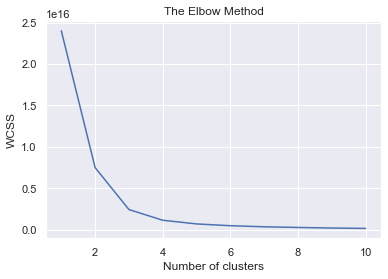

In [22]:
wcss = [] 
for i in range (1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(k_data)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Analyse of K-Means: Elbow Method 
From the graph, we are able to tell that the cluster is best-formed when there are 6 clusters as the Within-Cluster-Sum-of-Squares (WCSS) is significantly reduced.

As such, we can split the data into 6 clusters. 

If we were to split the data into more clusters, the WCSS will drop as the distance between the clusters are maximised. 

In [23]:
# The following uses SciKit Learn KMeans instead of TimeSeries KMeans 

kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(k_data)
'''
# The following uses TimeSeries KMeans instead of SciKit Learn KMeans 
kmeans = TimeSeriesKMeans(n_clusters= 6, metric="euclidean", max_iter=5, random_state=0)
y_kmeans = kmeans.fit_predict(k_data)
'''

'\n# The following uses TimeSeries KMeans instead of SciKit Learn KMeans \nkmeans = TimeSeriesKMeans(n_clusters= 6, metric="euclidean", max_iter=5, random_state=0)\ny_kmeans = kmeans.fit_predict(k_data)\n'

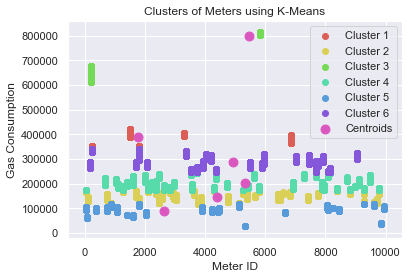

In [24]:
sns.set_palette(sns.color_palette("hls", 7))

plt.scatter(k_data[y_kmeans == 0, 0], k_data[y_kmeans == 0, 1], label = 'Cluster 1')
plt.scatter(k_data[y_kmeans == 1, 0], k_data[y_kmeans == 1, 1], label = 'Cluster 2')
plt.scatter(k_data[y_kmeans == 2, 0], k_data[y_kmeans == 2, 1], label = 'Cluster 3')
plt.scatter(k_data[y_kmeans == 3, 0], k_data[y_kmeans == 3, 1], label = 'Cluster 4')
plt.scatter(k_data[y_kmeans == 4, 0], k_data[y_kmeans == 4, 1], label = 'Cluster 5')
plt.scatter(k_data[y_kmeans == 5, 0], k_data[y_kmeans == 5, 1], label = 'Cluster 6')

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s = 80, label = 'Centroids')

plt.title('Clusters of Meters using K-Means')
plt.xlabel('Meter ID')
plt.ylabel('Gas Consumption')
plt.legend()
plt.show()

In [25]:
house_cluster = {} 
check_list = []
repeated = []

for cluster in range (6):
    listed = []
    for dataid in (k_data[y_kmeans==cluster,0]):
        if (house_cluster.get(str(dataid)) == None):
            house_cluster.setdefault(cluster, [])

            if dataid not in listed:
                listed.append(dataid)
                if (any(dataid in z for z in check_list)):
                    repeated.append(dataid)              
        else:
            continue
    house_cluster[cluster] = (listed)
    check_list.append(listed)


print(f"There are a total of {len(house_cluster)} clusters formed. \n")
for key in house_cluster:
    print(f"Cluster {key} contains the following houses: {(house_cluster[key])}\n")
print(f"There are {len(repeated)} houses classified in 2 or more clusters. \n")
print(f"These houses with 2 or more clusters are: {repeated}. \n")
    

There are a total of 6 clusters formed. 

Cluster 0 contains the following houses: [1507, 6863, 3310, 252, 1790]

Cluster 1 contains the following houses: [3635, 1714, 6412, 7429, 5275, 4296, 8829, 3039, 9295, 3577, 4767, 5785, 7739, 114, 1791, 9729, 1283, 1792, 2638, 2461, 744, 1800, 2980, 2094, 3849, 2129, 2575, 3778, 2378, 6830, 9766, 6578, 6505, 5395, 44, 2945, 2818, 8386, 5658, 9278, 1801, 3036, 9600, 9631, 871, 5131]

Cluster 2 contains the following houses: [222, 5814]

Cluster 3 contains the following houses: [6910, 4352, 1589, 7287, 9121, 4732, 5439, 9474, 2018, 8155, 5636, 7682, 3723, 661, 1042, 4373, 7900, 3527, 4356, 2965, 8086, 1415, 2233, 2470, 8703, 7965, 2129, 8967, 1103, 3577, 2638, 1283, 4296, 8386, 2378, 5785, 2094, 2818, 9295, 9766, 5275, 44, 8829]

Cluster 4 contains the following houses: [739, 9849, 5131, 871, 1086, 9631, 4447, 2034, 370, 35, 8467, 9278, 9956, 1801, 3893, 77, 1619, 4421, 8084, 4228, 8059, 5317, 8244, 1403, 6673]

Cluster 5 contains the following h

## Conclusion of using K-Means Clustering 
The distance measuring used in standard clustering algorithms such as Euclidean distance is not appropriate to be used with time series. A better approach will be to replace the default distance measure with Dynamic Time Warping. 

In this case where Euclidean Distance is used, the time dimensions of the data will be ignored, as such we are unable to apply Dynamic Time Warping with K-Means Clustering. 

As the data varies with time, we have identified K-Means Clustering as a bad method to classify the households. In addition, using K-Means Clustering causes the some households to be classified in more than one cluster. 

The key difference of Hierarchical Clustering when comparing with K-Means Clustering is that it does not require to pre-specify the number of clusters to be generated. Additionally, one of the main advantages of Hierarchical Clustering is having the dendrogram which is a very intuitive tree-based representation of the observations. Furthermore, when the Hierarchical Clustering is being paired with Dynamic Time Warping, the clustering results becomes more reliable as Dynamic Time Warping is able to capture the dissimilarity between the gas consumption data. However, the limitation to our solution is the time complexity.

# 4. Long Short-Term Memory (LSTM) for forecasting

Since the dataset provided is time-series data, such that the data points are indexed in time order, we decided to use a class of neural networks known as the Recurrent Neural Network (RNN) to forecast the future time-series data. Like Feedforward and Convolutional Neural Networks (CNNs), RNN utilises training data to learn. However, the main difference between RNN and the other neural networks is the “memory” element of it. RNN can remember the information from prior inputs and use them to influence the current input and the output. Although traditional deep neural networks assume that input and output are independent of one another, the output obtained from using RNN is dependent on the prior elements within the sequence. In the case of analysing our gas consumption dataset, this can be beneficial since we are then able to better predict the consumption of a particular household or group of households (with similar gas consumption rate) accurately. This allows gas companies to strategize their corresponding market strategies, business decisions, and operation cost more effectively. 

Despite RNN being a great prediction model, it has a downside of  “short-term memory”. For instance, if a sequence is long enough, the networks will have a hard time carrying information from earlier time steps to later ones, which will lead to missing important information from the beginning to a time when this information is required. This will result in a less accurate prediction. Since the gas consumption dataset has a broad time difference, this suggests that the sequence of  RNN is long, and implementing RNN alone would risk having a less precise prediction. 

The above explanation brings us to the reason for choosing a special kind of RNN known as the Long Short-Term Memory Networks (LSTM), which can learn long-term dependencies. In simpler terms,  LSTM can remember information from a long time ago and use it to influence the current result or output, thereby resulting in higher accuracy. The main working principles of LSTM are its cell states and gates. The cell state is essentially the “memory” of the network such that it can carry pertinent information throughout the processing sequence. Therefore, data from earlier time steps can also reach the later ones, reducing the effects of short-term memory. As the cell state carries on its journey down the processing lane, information can be added or removed via the gates, depending if they might be of help in giving the final predicted result. The gates will learn what information is relevant to keep or discard during the training phase. 

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from pandas import Series 
import seaborn as sns
sns.set()
sns.set_palette(sns.color_palette("hls", 4))
import collections
from datetime import datetime
import dateutil
import scipy
import tensorflow as tf

In [27]:
# Defining useful functions

scaler = MinMaxScaler(feature_range = (False, True))

# Normalize the dataset
def get_normalized_dataset(meter_value):
    dataset = ((hourly_data_df[meter_value].values).astype("float32")).reshape(-1, 1)
    dataset = scaler.fit_transform(dataset)
    return dataset

# Applying scaler inverse function
def scaler_transform(data_type):
    return scaler.inverse_transform(data_type)

# For reshaping purposes 
def get_shape(data_type, value):
    return data_type.shape[value]

# Split data into train and test sets
def split_data(dataset):
    length_of_training = int(len(dataset) * 0.8)
    length_of_dataset = len(dataset)
    train_data, test_data = dataset[:length_of_training][:], dataset[length_of_training:length_of_dataset][:]
    splited_data = train_data, test_data
    return splited_data

# Convert an array of values into a dataset matrix
def prep_lstm_data(dataset):
    x, y = [], []
    length_of_dataset = len(dataset)
    relevant_dataset = dataset[:length_of_dataset-2]
    for i, j in enumerate(relevant_dataset):
        a = dataset[i:i+1, 0]
        x.append(a)
        y.append(dataset[i+1, 0])
    return np.array(x), np.array(y)

# Plotting the LSTM graph
def plot_LSTM(meter_value, train_pred_y, test_pred_y, train_data, test_data):
    plt.subplots(figsize=(28,7))
    plt.scatter(train_date, scaler_transform(train_data))
    plt.scatter(test_date, scaler_transform(test_data))
    plt.scatter(train_date[:-2], train_pred_y)
    plt.scatter(test_date[:-2], test_pred_y)
    
    plt.xticks(fontsize=25)
    plt.xlabel('Time', fontsize=25)
    plt.ylabel('Amount of gas consumed', fontsize=25)
    plt.title(f'Meter {meter_value} Cumulative gas consumption vs Time with LSTM', fontsize=25)
    plt.legend(['Train data', 'Test data', 'Best fit line train', "Best fit line test",'Prediction'], fontsize=25)
    plt.show()




### Visualising Meter 35 SVR best actual vs fit line and forcasting and using LSTM

In [28]:
# Get readings 

meter_reading = 35

dataset = get_normalized_dataset(meter_reading)
splited_data = split_data(dataset)
train_data, test_data = splited_data

# Modelling

test_x, test_y = prep_lstm_data(test_data)
train_x, train_y = prep_lstm_data(train_data)

train_x = np.reshape(train_x, (get_shape(train_x, 0), 1, get_shape(train_x, 1)))
test_x = np.reshape(test_x, (get_shape(test_x, 0), 1, get_shape(test_x, 1)))

model = Sequential()
model.add(LSTM(10, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=50, batch_size=5, verbose=2)

train_pred_y, train_y = scaler_transform(model.predict(train_x)), scaler_transform([train_y])
test_pred_y, test_y  = scaler_transform(model.predict(test_x)), scaler_transform([test_y])

a, b = train_pred_y, test_pred_y

# Mean Squared Error
print('Training mean squared error: %.2f' % (mean_squared_error(train_y[0], train_pred_y[:,0])))
print('Test mean squared error: %.2f' % (mean_squared_error(test_y[0], test_pred_y[:,0])))

Epoch 1/50
703/703 - 1s - loss: 0.0273
Epoch 2/50
703/703 - 1s - loss: 1.2685e-04
Epoch 3/50
703/703 - 1s - loss: 8.0986e-05
Epoch 4/50
703/703 - 1s - loss: 5.3445e-05
Epoch 5/50
703/703 - 1s - loss: 2.8485e-05
Epoch 6/50
703/703 - 1s - loss: 1.1491e-05
Epoch 7/50
703/703 - 1s - loss: 4.3390e-06
Epoch 8/50
703/703 - 1s - loss: 2.8546e-06
Epoch 9/50
703/703 - 1s - loss: 2.6280e-06
Epoch 10/50
703/703 - 1s - loss: 2.7783e-06
Epoch 11/50
703/703 - 1s - loss: 2.9590e-06
Epoch 12/50
703/703 - 1s - loss: 2.7220e-06
Epoch 13/50
703/703 - 1s - loss: 3.3970e-06
Epoch 14/50
703/703 - 1s - loss: 3.1177e-06
Epoch 15/50
703/703 - 1s - loss: 3.2784e-06
Epoch 16/50
703/703 - 1s - loss: 3.0369e-06
Epoch 17/50
703/703 - 1s - loss: 2.6854e-06
Epoch 18/50
703/703 - 1s - loss: 2.6095e-06
Epoch 19/50
703/703 - 1s - loss: 2.5252e-06
Epoch 20/50
703/703 - 1s - loss: 2.4381e-06
Epoch 21/50
703/703 - 1s - loss: 2.7202e-06
Epoch 22/50
703/703 - 1s - loss: 2.4217e-06
Epoch 23/50
703/703 - 1s - loss: 2.2325e-06
E

NameError: name 'train_date' is not defined

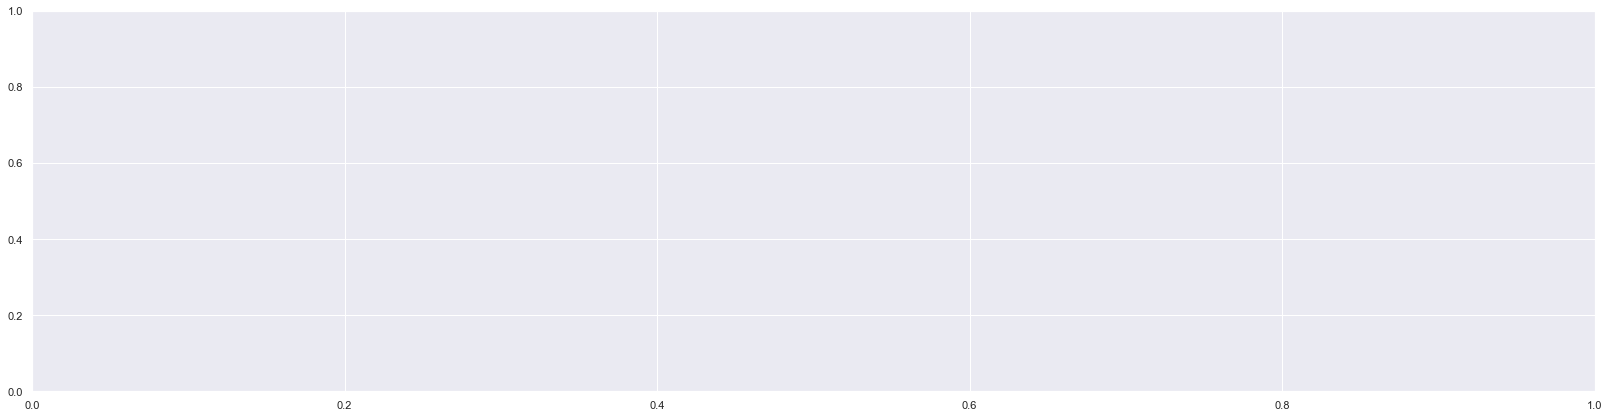

In [29]:
# Get LSTM plot
plot_LSTM(35, a, b, train_data, test_data)

### Visualising Meter 77 SVR best actual vs fit line and forcasting and using LSTM


In [ ]:
# Get readings 

meter_reading = 77

dataset = get_normalized_dataset(meter_reading)
splited_data = split_data(dataset)
train_data, test_data = splited_data

# Modelling

test_x, test_y = prep_lstm_data(test_data)
train_x, train_y = prep_lstm_data(train_data)

train_x = np.reshape(train_x, (get_shape(train_x, 0), 1, get_shape(train_x, 1)))
test_x = np.reshape(test_x, (get_shape(test_x, 0), 1, get_shape(test_x, 1)))

model = Sequential()
model.add(LSTM(10, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=50, batch_size=5, verbose=2)

train_pred_y, train_y = scaler_transform(model.predict(train_x)), scaler_transform([train_y])
test_pred_y, test_y  = scaler_transform(model.predict(test_x)), scaler_transform([test_y])

a, b = train_pred_y, test_pred_y

# Mean Squared Error
print('Training mean squared error: %.2f' % (mean_squared_error(train_y[0], train_pred_y[:,0])))
print('Test mean squared error: %.2f' % (mean_squared_error(test_y[0], test_pred_y[:,0])))

Epoch 1/50
703/703 - 1s - loss: 0.0331
Epoch 2/50
703/703 - 1s - loss: 4.1547e-04
Epoch 3/50
703/703 - 1s - loss: 6.0048e-05
Epoch 4/50
703/703 - 1s - loss: 4.5559e-05
Epoch 5/50
703/703 - 1s - loss: 3.0491e-05
Epoch 6/50
703/703 - 1s - loss: 1.7198e-05
Epoch 7/50
703/703 - 1s - loss: 8.4464e-06
Epoch 8/50
703/703 - 1s - loss: 4.3975e-06
Epoch 9/50
703/703 - 1s - loss: 3.3332e-06
Epoch 10/50
703/703 - 2s - loss: 3.2824e-06
Epoch 11/50
703/703 - 2s - loss: 3.4259e-06
Epoch 12/50
703/703 - 2s - loss: 3.7187e-06
Epoch 13/50
703/703 - 2s - loss: 3.5377e-06
Epoch 14/50
703/703 - 2s - loss: 3.4809e-06
Epoch 15/50
703/703 - 1s - loss: 3.7915e-06
Epoch 16/50
703/703 - 1s - loss: 3.3883e-06
Epoch 17/50
703/703 - 1s - loss: 3.8498e-06
Epoch 18/50
703/703 - 2s - loss: 2.9725e-06
Epoch 19/50
703/703 - 1s - loss: 3.2636e-06
Epoch 20/50
703/703 - 1s - loss: 3.1647e-06
Epoch 21/50
703/703 - 1s - loss: 2.9905e-06
Epoch 22/50
703/703 - 1s - loss: 3.1182e-06
Epoch 23/50
703/703 - 2s - loss: 2.7869e-06
E

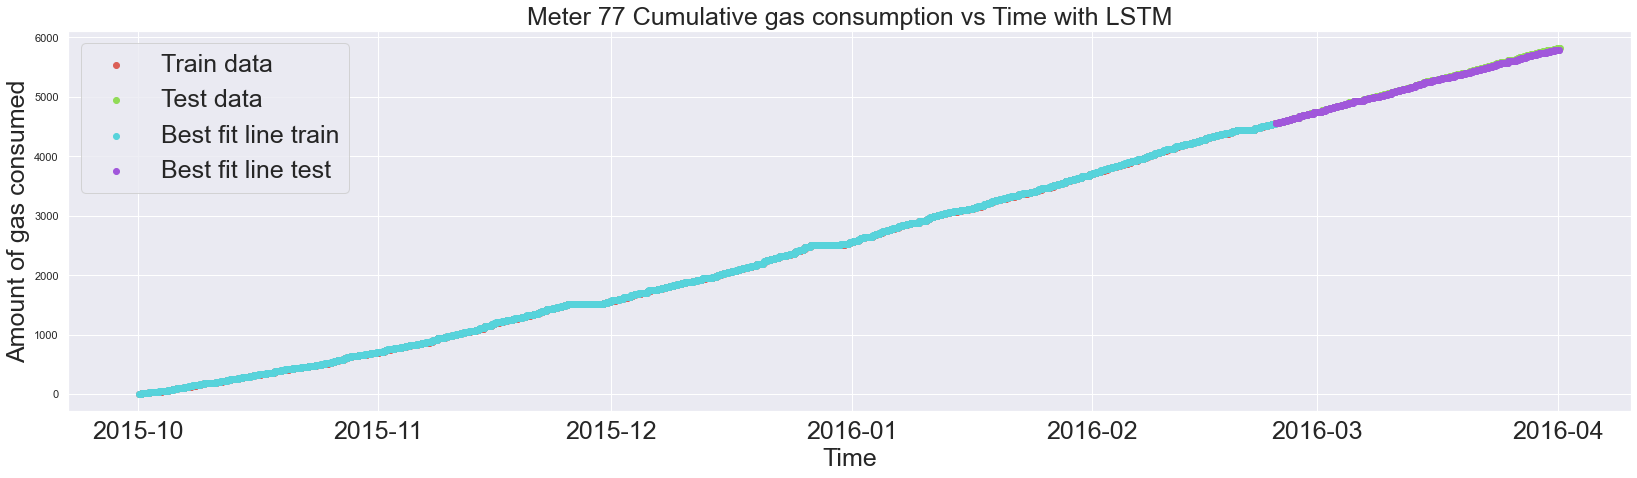

In [ ]:
# Get LSTM plot
plot_LSTM(meter_reading, a, b, train_data, test_data)

### Visualising Meter 9849 SVR best actual vs fit line and forcasting and using LSTM

In [ ]:
# Get readings 

meter_reading = 9849

dataset = get_normalized_dataset(meter_reading)
splited_data = split_data(dataset)
train_data, test_data = splited_data

# Modelling

test_x, test_y = prep_lstm_data(test_data)
train_x, train_y = prep_lstm_data(train_data)

train_x = np.reshape(train_x, (get_shape(train_x, 0), 1, get_shape(train_x, 1)))
test_x = np.reshape(test_x, (get_shape(test_x, 0), 1, get_shape(test_x, 1)))

model = Sequential()
model.add(LSTM(10, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=50, batch_size=5, verbose=2)

train_pred_y, train_y = scaler_transform(model.predict(train_x)), scaler_transform([train_y])
test_pred_y, test_y  = scaler_transform(model.predict(test_x)), scaler_transform([test_y])

a, b = train_pred_y, test_pred_y

# Mean Squared Error
print('Training mean squared error: %.2f' % (mean_squared_error(train_y[0], train_pred_y[:,0])))
print('Test mean squared error: %.2f' % (mean_squared_error(test_y[0], test_pred_y[:,0])))

Epoch 1/50
703/703 - 1s - loss: 0.0255
Epoch 2/50
703/703 - 1s - loss: 1.0473e-04
Epoch 3/50
703/703 - 1s - loss: 2.4475e-05
Epoch 4/50
703/703 - 1s - loss: 1.7619e-05
Epoch 5/50
703/703 - 1s - loss: 1.1121e-05
Epoch 6/50
703/703 - 1s - loss: 6.1941e-06
Epoch 7/50
703/703 - 1s - loss: 3.4276e-06
Epoch 8/50
703/703 - 1s - loss: 2.6279e-06
Epoch 9/50
703/703 - 1s - loss: 2.5109e-06
Epoch 10/50
703/703 - 1s - loss: 2.6732e-06
Epoch 11/50
703/703 - 1s - loss: 2.6493e-06
Epoch 12/50
703/703 - 1s - loss: 2.9998e-06
Epoch 13/50
703/703 - 1s - loss: 3.0826e-06
Epoch 14/50
703/703 - 1s - loss: 2.9627e-06
Epoch 15/50
703/703 - 1s - loss: 3.1497e-06
Epoch 16/50
703/703 - 1s - loss: 2.9556e-06
Epoch 17/50
703/703 - 1s - loss: 2.7175e-06
Epoch 18/50
703/703 - 1s - loss: 2.7666e-06
Epoch 19/50
703/703 - 1s - loss: 2.7698e-06
Epoch 20/50
703/703 - 1s - loss: 3.0663e-06
Epoch 21/50
703/703 - 1s - loss: 2.6581e-06
Epoch 22/50
703/703 - 1s - loss: 2.5818e-06
Epoch 23/50
703/703 - 1s - loss: 2.6958e-06
E

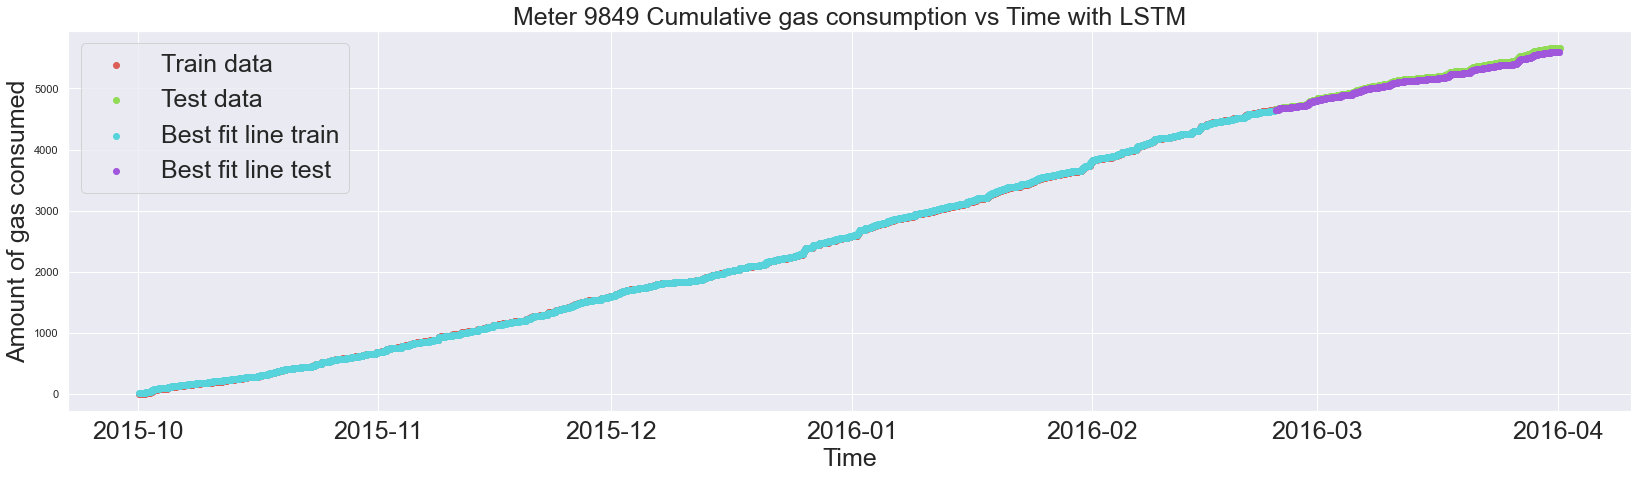

In [ ]:
# Get LSTM plot
plot_LSTM(meter_reading, a, b, train_data, test_data)

## Conclusion on LSTM

Comparing to Linear Regression, Support Vector Regression(SVR) with Linear Kernel and SVR with Radial Basis Function(RBF) Kernel (done in Question 2), LSTM has a much lower Mean Squared Error. Furthermore, from the LSTM plots obtained, we can observe that the fitted lines (both train and test) are very close to that of the actual lines. With this result, we can confidently forecast future time-series data.  

Such good performances can be indebted to the fact that in LSTM, the future data is reliant on the previous data. In addition, gas consumption is highly related to the time of the day; therefore, time is crucial at predicting such consumption. 

On a side note, the reason why Linear Regression and SVR (Linear and RBF) underperformed when compared to LSTM, is due to the “missing time component” in their algorithms. LSTM outperformed them because it “remembers” the earlier predicted outcome. 

# Overall Conclusion
To conclude, our group believes that Hierarchical Clustering paired with Dynamic Time Warping is suitable for clustering the household, whereas LSTM is suitable for forecasting gas consumption data within Texas, as it has the lowest Mean Squared Error, as compared to other forecasting methods such as Linear Regression, Linear SVR and RBF SVR.

# References

Altché, F., & Fortelle, A. D. L. (2017). An LSTM network for highway trajectory prediction. In Proceedings of the IEEE 20th International Conference on Intelligent Transportation Systems. Piscataway, NJ: IEEE.

Amidon, A. (2020, September 22). How to apply K-means clustering to time series data. Medium. https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data-28d04a8f7da3

Dynamic time warping clustering. (n.d.). Cross Validated. https://stats.stackexchange.com/questions/131281/dynamic-time-warping-clustering

He, T., & Droppo, J. (2016). Exploiting LSTM structure in deep neural networks for speech recognition. In Proceedings of the IEEE International Conference on Acoustics, Speech and Signal Processing (pp. 5445–5449). Piscataway, NJ: IEEE.

Patlolla, C. R. (2020, May 29). Understanding the concept of hierarchical clustering technique. Medium. https://towardsdatascience.com/understanding-the-concept-of-hierarchical-clustering-technique-c6e8243758ec

Shyalika, C. (2019, May 24). Dynamic time warping (DTW). Medium. https://medium.com/datadriveninvestor/dynamic-time-warping-dtw-d51d1a1e4afc

Understanding dynamic time warping. (2020, September 8). Databricks. https://databricks.com/blog/2019/04/30/understanding-dynamic-time-warping.html

What is a distance matrix? (2019, May 15). Displayr. https://www.displayr.com/what-is-a-distance-matrix/

Zhang, J. (2020, February 14). Dynamic time warping. Medium. https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd

